#Single-Fidelity NN Surrogate (Multi-Output)

In [1]:
from IPython.display import clear_output

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"
clear_output()

In [4]:
!pip install emukit
clear_output()
print('Emukit installed')

Emukit installed


In [5]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
%matplotlib inline

np.random.seed(20)

In [6]:
# TensorFlow imports
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [7]:
!ls "/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation"

data_generation_50percent.ipynb  High-Fidelity
data_generation.ipynb		 Low-Fidelity


In [8]:
#High-Fidelity (HF) and Low-Fidelity (LF) data
X_hf = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/High-Fidelity/CM3/input_data_permeability_50percent.npy')
Y_hf = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/High-Fidelity/CM3/output_data_permeability_50percent.npy')

X_lf = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/Low-Fidelity/CM3/input_data_200_permeability_50percent.npy')
Y_lf = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/Low-Fidelity/CM3/output_data_200_permeability_50percent.npy')
#Y_lf = Y_lf[:,:2] #pequeña correción para dejar Y_lf con 2 columnas, esto se debe arreglar

# 1 Additional samples for HF and LF, with the particularity that each Xi is the same for both, could serve as a Testing or Validation Data
X_hf_100 = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/High-Fidelity/CM3/X_hf_100_new.npy')
Y_hf_100 = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/High-Fidelity/CM3/Y_hf_100_new.npy')

X_lf_100 = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/Low-Fidelity/CM3/X_lf_100_new.npy')
Y_lf_100 = np.load('/content/drive/My Drive/Colab Notebooks/UQ Lung/1 Generated Data from Simulations/data_generation/Low-Fidelity/CM3/Y_lf_100_new.npy')

print("X HF size :", X_hf.shape)
print("Y HF size :", Y_hf.shape)
print("X LF size :", X_lf.shape)
print("Y LF size :", Y_lf.shape)
print("")
print("Additional X HF size :", X_hf_100.shape)
print("Additional Y HF size :", Y_hf_100.shape)
print("Additional X LF size :", X_lf_100.shape)
print("Additional Y LF size :", Y_lf_100.shape)

X HF size : (20, 6)
Y HF size : (20, 2)
X LF size : (200, 6)
Y LF size : (200, 2)

Additional X HF size : (100, 6)
Additional Y HF size : (100, 2)
Additional X LF size : (100, 6)
Additional Y LF size : (100, 2)


In [9]:
from sklearn.model_selection import train_test_split
# Next the LF and HF data is split into Training and Testing set
X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_test_100 = X_hf_100
Y_hf_test_100 = Y_hf_100

X_lf_test_100 = X_lf_100
Y_lf_test_100 = Y_lf_100

In [10]:
from sklearn.preprocessing import StandardScaler

## Normalize input data
scaler = StandardScaler()

X_lf_train = scaler.fit_transform(X_lf_train)
X_lf_test = scaler.transform(X_lf_test)
X_lf_test_100 = scaler.transform(X_lf_test_100)

X_hf_train = scaler.fit_transform(X_hf_train)
X_hf_test = scaler.transform(X_hf_test)
X_hf_test_100 = scaler.transform(X_hf_test_100)

In [11]:
input_dim = X_hf_train.shape[1]
output_dim = Y_hf_train.shape[1]

input_dim,output_dim

(6, 2)

In [12]:
def build_model_6(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [13]:
model = build_model_6(0.1)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                420       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 2)                 122       
                                                                 
Total params: 7,862
Trainable params: 7,862
Non-trainable params: 0
_________________________________________________________________


In [15]:
example_result = model.predict(X_hf_test)
example_result

1/1 [==============================] - 0s 220ms/step


array([[ 0.07156514, -0.15298535]], dtype=float32)

In [16]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10000

model.fit(X_hf_train, Y_hf_train,epochs=EPOCHS, verbose=0,callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [17]:
test_predictions = model.predict(X_hf_test)

1/1 [==============================] - 0s 54ms/step


In [18]:
Y_hf_test

array([[  2.9860831 , 111.96977426]])

In [19]:
test_predictions

array([[  3.9853978, 109.023735 ]], dtype=float32)

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [21]:
# H-F predictions
print("H-F predictions")
mse = mean_squared_error(Y_hf_test[:,0], test_predictions[:,0])
print('\nMSE R: {}'.format(mse))

mse = mean_squared_error(Y_hf_test[:,1], test_predictions[:,1])
print('\nMSE C: {}'.format(mse))

H-F predictions

MSE R: 0.9986298922491142

MSE C: 8.67914704264446


nan
nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


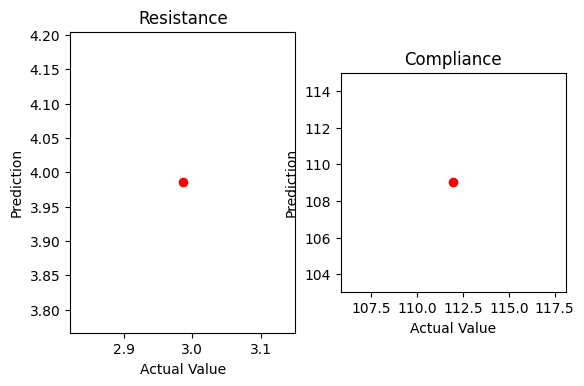

In [22]:
# We plot the additional samples data and compare HF vs LF via mappiing
from sklearn.metrics import r2_score

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(Y_hf_test[:,0], test_predictions[:,0], color = 'red')
ax1.set_xlabel('Actual Value')
ax1.set_ylabel('Prediction')
ax1.set_aspect('equal', 'box')
ax1.set_title("Resistance")

r2_c = r2_score(Y_hf_test[:,0], test_predictions[:,0])
#print('\nr2: {}'.format(r2))
#ax1.annotate("r² = {:.3f}".format(r2_c),(98,128))   


ax2.scatter(Y_hf_test[:,1], test_predictions[:,1], color = 'red')
ax2.set_xlabel('Actual Value')
ax2.set_ylabel('Prediction')
ax2.set_aspect('equal', 'box')
ax2.set_title("Compliance")

r2_r = r2_score(Y_hf_test[:,1], test_predictions[:,1])
#print('\nr2: {}'.format(r2))
#ax2.annotate("r² = {:.3f}".format(r2_r),(3.77,4.07))
print(r2_r)
print(r2_c)

4/4 [==============================] - 0s 3ms/step
-0.21874377189202288
0.9268409747561314


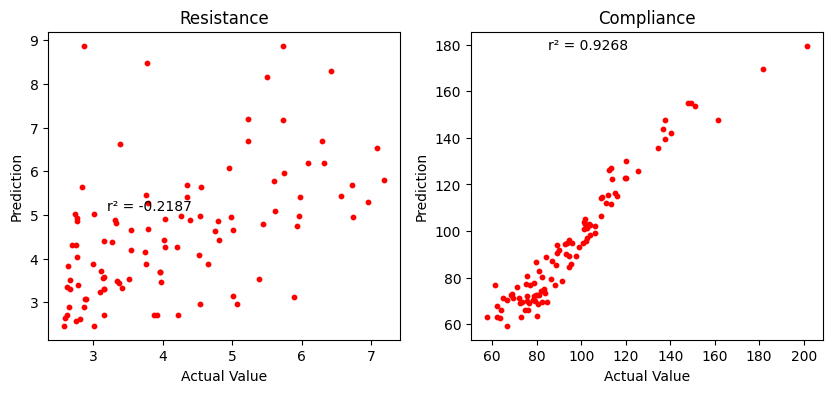

In [23]:
# We plot the additional samples data and compare HF vs LF via mappiing
indice = [list(range(1,100+1))]

test_predictions = model.predict(X_hf_test_100)

Y_test_100_C = Y_hf_test_100[:,1]
Y_pred_mean_C = test_predictions[:,1]

Y_test_100_R = Y_hf_test_100[:,0]
Y_pred_mean_R = test_predictions[:,0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(Y_test_100_R, Y_pred_mean_R, color = 'red', s=10)
ax1.set_xlabel('Actual Value')
ax1.set_ylabel('Prediction')
#ax1.set_aspect('equal', 'box')
ax1.set_title("Resistance")

r2_r = r2_score(Y_test_100_R, Y_pred_mean_R)
#print('\nr2: {}'.format(r2))
#ax1.annotate("r² = {:.3f}".format(r2_c),(98,128))   


ax2.scatter(Y_test_100_C, Y_pred_mean_C, color = 'red', s=10)
ax2.set_xlabel('Actual Value')
ax2.set_ylabel('Prediction')
#ax2.set_aspect('equal', 'box')
ax2.set_title("Compliance")

r2_c = r2_score(Y_test_100_C, Y_pred_mean_C)
#print('\nr2: {}'.format(r2))
ax1.annotate("r² = {:.4f}".format(r2_r),(3.2,5.1))
ax2.annotate("r² = {:.4f}".format(r2_c),(85,178))
print(r2_r)
print(r2_c)

4/4 [==============================] - 0s 3ms/step

MSE H-F: 50.325472189758074

r2: 0.9268409747561314


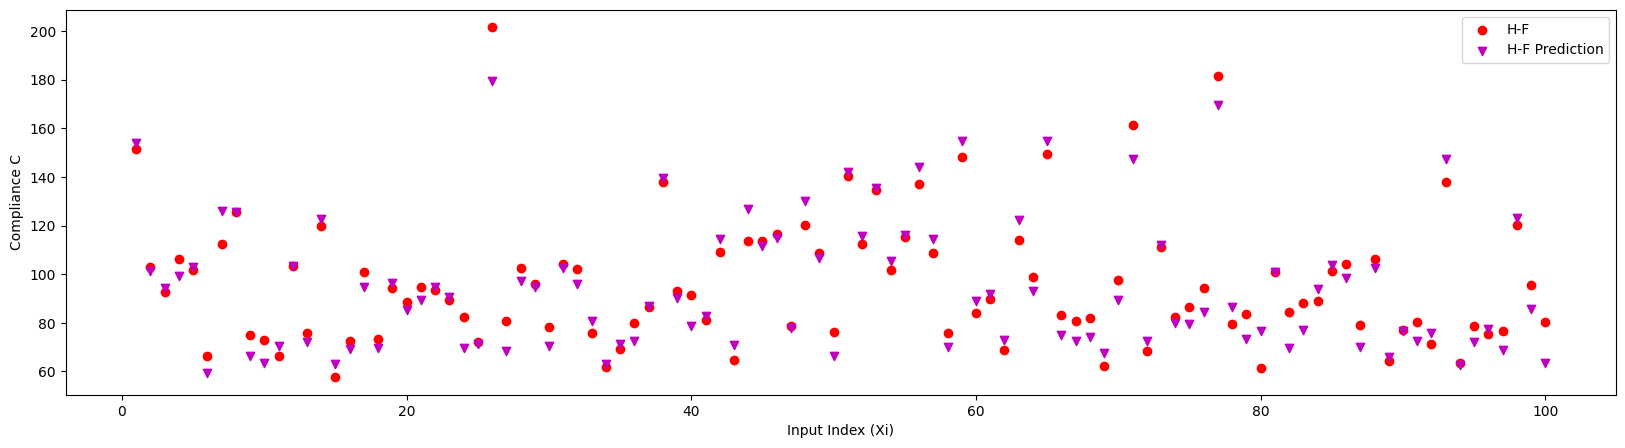

In [24]:
indice = [list(range(1,100+1))]

test_predictions = model.predict(X_hf_test_100)

Y_test_100_C = Y_hf_test_100[:,1]
Y_pred_mean_C = test_predictions[:,1]

plt.figure(figsize=(20, 5))
plt.scatter(indice, Y_test_100_C, color ='r', label = 'H-F')
plt.scatter(indice, Y_pred_mean_C, color = 'm', marker = "v", label = 'H-F Prediction')
plt.xlabel("Input Index (Xi)")
plt.ylabel("Compliance C")
plt.legend()


mse = mean_squared_error(Y_test_100_C, Y_pred_mean_C)
print('\nMSE H-F: {}'.format(mse))

r2 = r2_score(Y_test_100_C, Y_pred_mean_C)
print('\nr2: {}'.format(r2))

In [25]:
# Export values
np.save('NN_C_50percent.npy', Y_pred_mean_C)
np.save('NN_R_50percent.npy', Y_pred_mean_R)

In [26]:
hasta acá

SyntaxError: ignored

In [ ]:
def build_model_6(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
#split_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#split_list = [0.5, 0.55, 0.57, 0.6, 0.65, 0.67, 0.7, 0.75, 0.77, 0.8, 0.85, 0.87, 0.9, 0.95, 0.97]
#split_list = [0.5, 0.55, 0.57, 0.6, 0.65, 0.67, 0.7, 0.75, 0.77, 0.8, 0.85, 0.87, 0.9, 0.95, 0.97]
#split_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#split_list_1 = [0.5, 0.55, 0.6, 0.65, 0.7]
#split_list_2 = [0.75, 0.8, 0.85, 0.9, 0.95]
split_list_1 = [0.5, 0.55, 0.6, 0.65, 0.7]
split_list_2 = [0.75, 0.8, 0.85, 0.9, 0.95]
#split_list = [0.5, 0.6]
#random_list = [1,2,3,4,5,6,7,8,9,10]
random_list = np.arange(1, 100+1,10)
RMSE_list_R_1 = []
RMSE_list_C_1 = []
std_R_1 = []
std_C_1 = []

for split in split_list_1:
  print("Train split: ", split)
  RMSE_inner_list_R = []
  RMSE_inner_list_C = []
  for random_number in random_list:
    # Split
    X_lf_train, X_lf_test = train_test_split(X_lf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_train, X_hf_test = train_test_split(X_hf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_test_100 = X_hf_100
    Y_hf_test_100 = Y_hf_100

    X_lf_test_100 = X_lf_100
    Y_lf_test_100 = Y_lf_100


    # Normalize
    scaler = StandardScaler()

    X_lf_train = scaler.fit_transform(X_lf_train)
    X_lf_test = scaler.transform(X_lf_test)
    X_lf_test_100 = scaler.transform(X_lf_test_100)

    X_hf_train = scaler.fit_transform(X_hf_train)
    X_hf_test = scaler.transform(X_hf_test)
    X_hf_test_100 = scaler.transform(X_hf_test_100)

    # Train
    input_dim = X_hf_train.shape[1]
    output_dim = Y_hf_train.shape[1]

    model = build_model_6(0.1)

    print(X_hf_train.shape)

    # Display training progress by printing a single dot for each completed epoch
    class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

    EPOCHS = 10000

    model.fit(X_hf_train, Y_hf_train, epochs=EPOCHS, verbose=0)

    # Evaluate
    Y_pred_mean = model.predict(X_hf_test_100)
    # H-F predictions
    print("H-F predictions")
    mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
    print('\nMSE R: {}'.format(mse_R))
    mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
    print('\nMSE C: {}'.format(mse_C))
    RMSE_inner_list_R.append(np.sqrt(mse_R))
    RMSE_inner_list_C.append(np.sqrt(mse_C))
  RMSE_list_R_1.append(np.average(RMSE_inner_list_R))
  RMSE_list_C_1.append(np.average(RMSE_inner_list_C))
  print(RMSE_inner_list_R)
  print(RMSE_inner_list_C)
  std_R_1.append(np.std(RMSE_inner_list_R))
  std_C_1.append(np.std(RMSE_inner_list_C))

#clear_output()

for i in range(len(split_list_1)):
  print("Train split: ", split_list_1[i], "||    MSE R: ", RMSE_list_R_1[i], "||    MSE C: ", RMSE_list_C_1[i], "||    std R: ", std_R_1[i], "||    std C: ", std_C_1[i])

In [ ]:
#plt.plot(np.arange(10,20),RMSE_list_C_1, marker = 'o')
#plt.fill_between(np.arange(10,20),np.asarray(RMSE_list_C_1) - np.asarray(std_C_1),np.asarray(RMSE_list_C_1) + np.asarray(std_C_1),alpha=.2)

In [ ]:
#plt.plot(np.arange(10,20),RMSE_list_R_1, marker = 'o')
#plt.fill_between(np.arange(10,20),np.asarray(RMSE_list_R_1) - np.asarray(std_R_1),np.asarray(RMSE_list_R_1) + np.asarray(std_R_1),alpha=.2)

In [ ]:
# Export values
np.save('RMSE_R_1_nn.npy', RMSE_list_R_1)
np.save('RMSE_C_1_nn.npy', RMSE_list_C_1)
np.save('std_R_1_nn.npy', std_R_1)
np.save('std_C_1_nn.npy', std_C_1)

In [ ]:
std_R_1

In [ ]:
#split_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#split_list = [0.5, 0.55, 0.57, 0.6, 0.65, 0.67, 0.7, 0.75, 0.77, 0.8, 0.85, 0.87, 0.9, 0.95, 0.97]
#split_list = [0.5, 0.55, 0.57, 0.6, 0.65, 0.67, 0.7, 0.75, 0.77, 0.8, 0.85, 0.87, 0.9, 0.95, 0.97]
#split_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
split_list_1 = [0.5, 0.55, 0.6, 0.65, 0.7]
split_list_2 = [0.75, 0.8, 0.85, 0.9, 0.95]
#split_list = [0.5, 0.6]
#random_list = [1,2,3,4,5,6,7,8,9,10]
random_list = np.arange(1, 100+1,10)
RMSE_list_R_2 = []
RMSE_list_C_2 = []
std_R_2 = []
std_C_2 = []

for split in split_list_2:
  print("Train split: ", split)
  RMSE_inner_list_R = []
  RMSE_inner_list_C = []
  for random_number in random_list:
    # Split
    X_lf_train, X_lf_test = train_test_split(X_lf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_train, X_hf_test = train_test_split(X_hf, train_size=split, shuffle=True, random_state=random_number) # this split the input data
    Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=split, shuffle=True, random_state=random_number) # this split the output data

    X_hf_test_100 = X_hf_100
    Y_hf_test_100 = Y_hf_100

    X_lf_test_100 = X_lf_100
    Y_lf_test_100 = Y_lf_100


    # Normalize
    scaler = StandardScaler()

    X_lf_train = scaler.fit_transform(X_lf_train)
    X_lf_test = scaler.transform(X_lf_test)
    X_lf_test_100 = scaler.transform(X_lf_test_100)

    X_hf_train = scaler.fit_transform(X_hf_train)
    X_hf_test = scaler.transform(X_hf_test)
    X_hf_test_100 = scaler.transform(X_hf_test_100)

    # Train
    input_dim = X_hf_train.shape[1]
    output_dim = Y_hf_train.shape[1]

    model = build_model_6(0.1)
    
    print(X_hf_train.shape)

    # Display training progress by printing a single dot for each completed epoch
    class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

    EPOCHS = 10000

    model.fit(X_hf_train, Y_hf_train, epochs=EPOCHS, verbose=0)

    # Evaluate
    Y_pred_mean = model.predict(X_hf_test_100)
    # H-F predictions
    print("H-F predictions")
    mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
    print('\nMSE R: {}'.format(mse_R))
    mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
    print('\nMSE C: {}'.format(mse_C))
    RMSE_inner_list_R.append(np.sqrt(mse_R))
    RMSE_inner_list_C.append(np.sqrt(mse_C))
  RMSE_list_R_2.append(np.average(RMSE_inner_list_R))
  RMSE_list_C_2.append(np.average(RMSE_inner_list_C))
  print(RMSE_inner_list_R)
  print(RMSE_inner_list_C)
  std_R_2.append(np.std(RMSE_inner_list_R))
  std_C_2.append(np.std(RMSE_inner_list_C))

#clear_output()

for i in range(len(split_list_2)):
  print("Train split: ", split_list_2[i], "||    MSE R: ", RMSE_list_R_2[i], "||    MSE C: ", RMSE_list_C_2[i], "||    std R: ", std_R_2[i], "||    std C: ", std_C_2[i])

In [ ]:
# Export values
np.save('RMSE_R_2_nn.npy', RMSE_list_R_2)
np.save('RMSE_C_2_nn.npy', RMSE_list_C_2)
np.save('std_R_2_nn.npy', std_R_2)
np.save('std_C_2_nn.npy', std_C_2)

**Grid search**

optimal hyperparameters:

alpha = 0.1

epocs = 10000

model_6

In [ ]:
# Split
X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=1) # this split the input data
Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=1) # this split the output data

X_hf_test_100 = X_hf_100
Y_hf_test_100 = Y_hf_100

X_lf_test_100 = X_lf_100
Y_lf_test_100 = Y_lf_100


# Normalize
scaler = StandardScaler()

X_lf_train = scaler.fit_transform(X_lf_train)
X_lf_test = scaler.transform(X_lf_test)
X_lf_test_100 = scaler.transform(X_lf_test_100)

X_hf_train = scaler.fit_transform(X_hf_train)
X_hf_test = scaler.transform(X_hf_test)
X_hf_test_100 = scaler.transform(X_hf_test_100)

# Train
input_dim = X_hf_train.shape[1]
output_dim = Y_hf_train.shape[1]

In [ ]:
def build_model_1(alpha):
  model = keras.Sequential([
    layers.Dense(60*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_2(alpha):
  model = keras.Sequential([
    layers.Dense(60*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_3(alpha):
  model = keras.Sequential([
    layers.Dense(60*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_4(alpha):
  model = keras.Sequential([
    layers.Dense(60*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(60*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
def build_model_5(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_6(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_7(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_8(alpha):
  model = keras.Sequential([
    layers.Dense(30*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(30*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
def build_model_9(alpha):
  model = keras.Sequential([
    layers.Dense(120*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_10(alpha):
  model = keras.Sequential([
    layers.Dense(120*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_11(alpha):
  model = keras.Sequential([
    layers.Dense(120*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_12(alpha):
  model = keras.Sequential([
    layers.Dense(120*2, activation='relu', input_shape=[input_dim]),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(120*2, activation='relu'),
    layers.Dense(2)
  ])

  optimizer = tf.keras.optimizers.Adam(
                  learning_rate=alpha)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 10+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_1(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 10+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_2(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 10+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_3(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_4(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_5(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_6(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_7(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_8(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_9(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_10(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_11(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R

In [ ]:
#alpha_l = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
#epocs_l = [10, 50, 100, 500, 1000, 5000, 10000, 20000]
random_list = np.arange(1, 50+1,1)
alpha_l = [0.1]
epocs_l = [10000]
RMSE_list_R = []
RMSE_list_C = []
std_R = []
std_C = []

for alpha in alpha_l:
  for epocs in epocs_l:
    RMSE_inner_list_R = []
    RMSE_inner_list_C = []
    for random_number in random_list:
      # Split
      X_lf_train, X_lf_test = train_test_split(X_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_lf_train, Y_lf_test = train_test_split(Y_lf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_train, X_hf_test = train_test_split(X_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the input data
      Y_hf_train, Y_hf_test = train_test_split(Y_hf, train_size=0.95, shuffle=True, random_state=random_number) # this split the output data

      X_hf_test_100 = X_hf_100
      Y_hf_test_100 = Y_hf_100

      X_lf_test_100 = X_lf_100
      Y_lf_test_100 = Y_lf_100

      # Normalize
      scaler = StandardScaler()

      X_lf_train = scaler.fit_transform(X_lf_train)
      X_lf_test = scaler.transform(X_lf_test)
      X_lf_test_100 = scaler.transform(X_lf_test_100)

      X_hf_train = scaler.fit_transform(X_hf_train)
      X_hf_test = scaler.transform(X_hf_test)
      X_hf_test_100 = scaler.transform(X_hf_test_100)

      # Train
      input_dim = X_hf_train.shape[1]
      output_dim = Y_hf_train.shape[1]

      print('alpha', alpha)
      print('epocs', epocs)
      model = build_model_12(alpha)
      EPOCHS = epocs

      history = model.fit(
        X_hf_train, Y_hf_train,
        epochs=EPOCHS, verbose=0)
      
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch
      hist.tail()

      loss, mae, mse = model.evaluate(X_hf_test, Y_hf_test, verbose=2)

      #print("Testing set Mean Abs Error: {:5.2f}".format(mae))
      # Evaluate
      Y_pred_mean = model.predict(X_hf_test_100)
      # H-F predictions
      #print("H-F predictions")
      mse_R = mean_squared_error(Y_hf_test_100[:,0], Y_pred_mean[:,0])
      #print('\nMSE R: {}'.format(mse_R))
      mse_C = mean_squared_error(Y_hf_test_100[:,1], Y_pred_mean[:,1])
      #print('\nMSE C: {}'.format(mse_C))
      print('RMSE R:', np.sqrt(mse_R))
      print('RMSE C:', np.sqrt(mse_C))
      print('r2 R', r2_score(Y_hf_test_100[:,0], Y_pred_mean[:,0]))
      print('r2 C', r2_score(Y_hf_test_100[:,1], Y_pred_mean[:,1]))
      RMSE_inner_list_R.append(np.sqrt(mse_R))
      RMSE_inner_list_C.append(np.sqrt(mse_C))
    RMSE_list_R.append(np.average(RMSE_inner_list_R))
    RMSE_list_C.append(np.average(RMSE_inner_list_C))
    std_R.append(np.std(RMSE_inner_list_R))
    std_C.append(np.std(RMSE_inner_list_C))

In [ ]:
RMSE_list_C, RMSE_list_R